<a href="https://colab.research.google.com/github/falakniaz/LED-Detection-YOLOv8/blob/main/OCC_Relay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import numpy as np
import csv
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [43]:
class AdaptiveWeightedKNN:
    """
    Adaptive Weighted KNN for OCC relay selection.
    Uses adaptive k based on data variance and weighted distance by feature importance.
    """
    def __init__(self, feature_weights, base_k=3, max_k=None, distance_weighted=False):
        """
        :param feature_weights: np.array of feature weights (sum ~1 recommended)
        :param base_k: minimal number of neighbors
        :param max_k: maximal number of neighbors
        :param distance_weighted: if True, do distance-weighted voting
        """
        self.feature_weights = np.array(feature_weights)
        self.base_k = base_k
        self.max_k = max_k
        self.distance_weighted = distance_weighted
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """
        Store training data.
        :param X: ndarray, shape (n_samples, n_features)
        :param y: ndarray, shape (n_samples,)
        """
        self.X_train = X
        self.y_train = y

    def _adaptive_k(self):
        """
        Compute adaptive k based on mean variance of training data.
        """
        if self.X_train is None:
            raise ValueError("Model not trained. Use fit() first.")
        var = np.var(self.X_train, axis=0).mean()
        adaptive_k = int(self.base_k + var * 10)
        if self.max_k:
            adaptive_k = min(adaptive_k, self.max_k)
        adaptive_k = min(adaptive_k, len(self.X_train))
        return max(adaptive_k, 1)

    def _weighted_distance(self, x1, x2):
        """
        Compute weighted Euclidean distance.
        """
        return np.sqrt(np.sum(self.feature_weights * (x1 - x2) ** 2))

    def adapt_feature_weights(self, recent_metrics_window):

        variances = np.var(recent_metrics_window, axis=0)
        sum_var = np.sum(variances) + 1e-6
        new_weights = variances / sum_var
        self.feature_weights = new_weights
        print(f"Adaptive feature weights: {np.round(new_weights,3)}")


    def predict(self, new_sample):
        """
        Predict best relay for new sample.
        :param new_sample: ndarray, shape (n_features,)
        :return: predicted relay label
        """
        k = self._adaptive_k()
        distances = []
        for xi, yi in zip(self.X_train, self.y_train):
            d = self._weighted_distance(new_sample, xi)
            distances.append((d, yi))

        distances.sort(key=lambda x: x[0])
        nearest_k = distances[:k]

        if self.distance_weighted:
            # nearer neighbor → higher vote weight
            votes = Counter()
            for dist, label in nearest_k:
                weight = 1 / (dist + 1e-6)
                votes[label] += weight
            predicted = votes.most_common(1)[0][0]
        else:
            labels = [label for _, label in nearest_k]
            vote_counts = Counter(labels)
            predicted = vote_counts.most_common(1)[0][0]

        return predicted, nearest_k

    def save_dataset(self, filename):
        """
        Save dataset to CSV.
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("No dataset to save.")
        data = np.hstack((self.X_train, self.y_train.reshape(-1,1)))
        with open(filename, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerows(data)
        print(f"Dataset saved to {filename}")

    def load_dataset(self, filename):
        """
        Load dataset from CSV.
        """
        data = np.loadtxt(filename, delimiter=',')
        self.X_train = data[:, :-1]
        self.y_train = data[:, -1].astype(int)
        print(f"Dataset loaded from {filename}")

    def plot_decision_boundary(self):
        """
        Visualize dataset in 2D using PCA and show class distribution.
        """
        if self.X_train is None:
            raise ValueError("Model not trained.")
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(self.X_train)
        plt.figure(figsize=(6,6))
        for label in np.unique(self.y_train):
            idx = self.y_train == label
            plt.scatter(X_pca[idx,0], X_pca[idx,1], label=f"Relay {label}")
        plt.title("Dataset visualization (PCA)")
        plt.legend()
        plt.show()

In [44]:
# === Example usage ===
if __name__ == "__main__":
    # Example feature weights: [FDSR, SAR, Contrast, DropRate]
    feature_weights = np.array([0.4, 0.3, 0.1, 0.2])
    model = AdaptiveWeightedKNN(feature_weights, base_k=3, max_k=5, distance_weighted=True)

    # Example dataset: replace with real OCC metrics
    dataset = np.array([
        [0.95, 3.2, 0.5, 0.01, 1],
        [0.90, 2.8, 0.4, 0.05, 2],
        [0.88, 2.5, 0.3, 0.10, 3],
        [0.96, 3.5, 0.6, 0.02, 1],
        [0.89, 2.9, 0.45, 0.07, 2],
        [0.91, 3.0, 0.5, 0.03, 1]
    ])
    X = dataset[:, :-1]
    y = dataset[:, -1].astype(int)

    model.fit(X, y)

In [45]:
    # New sample from OCC testbed
    new_metrics = np.array([0.92, 3.1, 0.48, 0.04])

    predicted, neighbors = model.predict(new_metrics)
    print(f"\nPredicted best relay: Relay {predicted}")
    print("\nNearest neighbors:")
    for dist, label in neighbors:
        print(f"Relay {label}, distance={dist:.4f}")


Predicted best relay: Relay 1

Nearest neighbors:
Relay 1, distance=0.0557
Relay 1, distance=0.0598
Relay 2, distance=0.1124


Dataset saved to occ_dataset.csv
Dataset loaded from occ_dataset.csv


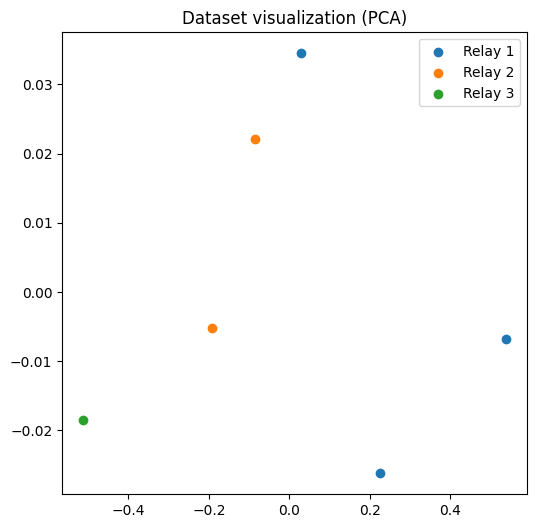

In [46]:

    # Optional: save/load
    model.save_dataset("occ_dataset.csv")
    model.load_dataset("occ_dataset.csv")

    # Optional: plot
    model.plot_decision_boundary()
